In [1]:
import pandas as pd
import numpy as np# nan 검사 math.isnan() or numpy
import math

## Data Summary

        ID : 샘플 고유 id
        항공편 운항 관련 정보
        Month: 해당 항공편의 출발 월
        Day_of_Month: Month에 해당하는 월의 날짜
        Estimated_Departure_Time: 전산 시스템을 바탕으로 측정된 비행기의 출발 시간 (HH:MM 형식) // 일부없음
        Estimated_Arrival_Time: 전산 시스템을 바탕으로 측정된 비행기의 도착 시간 (HH:MM 형식) // 일부없음
        Cancelled: 해당 항공편의 취소 여부 (0: 취소되지 않음, 1: 취소됨) // only 0
        Diverted: 해당 항공편의 경유 여부 (0: 취소되지 않음, 1: 취소됨) // only 0
        Origin_Airport: 해당 항공편 출발 공항의 고유 코드 (IATA 공항 코드)
        Origin_Airport_ID: 해당 항공편 출발 공항의 고유 ID (US DOT ID)
        Origin_State: 해당 항공편 출발 공항이 위치한 주의 이름 // 일부없음
        Destination_Airport: 해당 항공편 도착 공항의 고유 코드 (IATA 공항 코드)
        Destination_Airport_ID: 해당 항공편 도착 공항의 고유 ID (US DOT ID)
        Destination_State: 해당 항공편 도착 공항이 위치한 주의 이름 // 일부없음
        *Distance: 출발 공항과 도착 공항 사이의 거리 (mile 단위)
        *Airline: 해당 항공편을 운항하는 항공사 // 일부없음
        Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드 // 일부없음
        (IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
        Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID) // 일부없음
        Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호
        Delay: 항공편 지연 여부 (Not_Delayed, Delayed)
        예측해야 하는 타깃
        다수의 데이터에 레이블이 존재하지 않음
        준지도학습을 통해 레이블링 가능

        - model input columns list
                ID,Momth,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,  Distance,Carrier_ID(DOT),Tail_Number,Delay

In [2]:
dataPath = '~/dacon/delay_airline/'
Train_data = pd.read_csv(dataPath+'train.csv')
Train_data.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,NaN
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,NaN


In [3]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [4]:
Train_data.describe() # ploting list index 1,2 // 3,4,13

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,891003.000000
mean,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,12696.278484,12701.813986,784.078499,19997.388093
std,3.462506,8.763515,489.814011,520.803494,0.0,0.0,1514.938441,1515.213044,590.790469,404.268639
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,11292.000000,11292.000000,350.000000,19790.000000
50%,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,12889.000000,12889.000000,623.000000,19977.000000
75%,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,14057.000000,14057.000000,1020.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


In [5]:
#departureTime 과 ArrivalTime HH-MM 형식의 date type으로 바꿔야함

### Binary col analysis

In [6]:
Train_data.Cancelled.unique(),Train_data.Diverted.unique() # 1이 없다..?

(array([0]), array([0]))

#### NaN label 들여다보기

In [7]:
print(Train_data.Delay.value_counts())
print(Train_data.shape) # 75만 row를 label inference 해야함.

Not_Delayed    210001
Delayed         45000
Name: Delay, dtype: int64
(1000000, 19)


In [8]:
Delay_data =Train_data[Train_data.Delay == 'Delayed']
Notdelay_data =Train_data[Train_data.Delay == 'Not_Delayed']

In [9]:
Notdelay_data[Notdelay_data.iloc[:,14].isnull()]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
32,TRAIN_000032,6,20,750.0,1014.0,0,0,ORD,13930,Illinois,LEX,12945,Kentucky,323.0,NaN,UA,20366.0,N12900,Not_Delayed
56,TRAIN_000056,3,7,600.0,808.0,0,0,ALB,10257,NaN,MSP,13487,Minnesota,980.0,NaN,DL,20304.0,N832SK,Not_Delayed
112,TRAIN_000112,2,21,2020.0,2347.0,0,0,MSP,13487,Minnesota,DCA,11278,Virginia,931.0,NaN,NaN,19790.0,N324US,Not_Delayed
144,TRAIN_000144,8,22,550.0,838.0,0,0,PNS,14193,NaN,MIA,13303,Florida,530.0,NaN,AA,20398.0,N653AE,Not_Delayed
166,TRAIN_000166,11,19,1407.0,1725.0,0,0,DEN,11292,Colorado,IAH,12266,Texas,862.0,NaN,UA,19977.0,N64809,Not_Delayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999744,TRAIN_999744,10,14,2045.0,2326.0,0,0,ORD,13930,Illinois,AUS,10423,Texas,977.0,NaN,UA,19977.0,N848UA,Not_Delayed
999745,TRAIN_999745,12,8,800.0,1137.0,0,0,PHL,14100,Pennsylvania,SFO,14771,California,2521.0,NaN,AS,19930.0,N639VA,Not_Delayed
999769,TRAIN_999769,10,17,NaN,1653.0,0,0,MSP,13487,Minnesota,BIS,10627,North Dakota,386.0,NaN,DL,20304.0,N944SW,Not_Delayed
999791,TRAIN_999791,9,8,1305.0,1605.0,0,0,DEN,11292,Colorado,DAL,11259,Texas,651.0,NaN,NaN,19393.0,N218WN,Not_Delayed


#### origin airport col

In [10]:
'''
출발항공편 공항 기준 딜레이 안되는 카운팅
'''
origin_group = Notdelay_data.groupby(Notdelay_data['Origin_Airport'])['Delay'].count()
origin_group

Origin_Airport
ABE    149
ABI     39
ABQ    828
ABR     15
ABY     30
      ... 
XNA    384
XWA      4
YAK     28
YKM     36
YUM     41
Name: Delay, Length: 374, dtype: int64

In [11]:
'''
출발항공편 공항 기준 딜레이 카운팅
'''
origin_delaygroup = Delay_data.groupby(Delay_data['Origin_Airport'])['Delay'].count()
origin_delaygroup

Origin_Airport
ABE     33
ABI      8
ABQ    142
ABR      5
ABY      2
      ... 
XNA     63
XWA      3
YAK      3
YKM      8
YUM      4
Name: Delay, Length: 361, dtype: int64

In [12]:
delay_rate = origin_delaygroup / (origin_delaygroup + origin_group) 
delay_rate

Origin_Airport
ABE    0.181319
ABI    0.170213
ABQ    0.146392
ABR    0.250000
ABY    0.062500
         ...   
XNA    0.140940
XWA    0.428571
YAK    0.096774
YKM    0.181818
YUM    0.088889
Name: Delay, Length: 374, dtype: float64

<AxesSubplot:xlabel='Origin_Airport'>

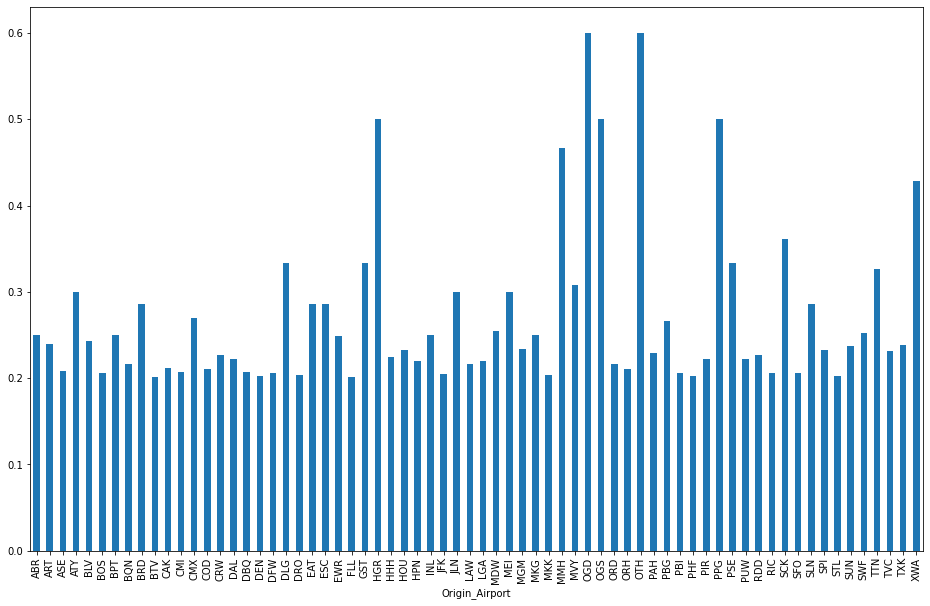

In [13]:
delay_rate[delay_rate > 0.2].plot(kind='bar',figsize=[16,10])

In [14]:
null_data =Train_data[Train_data.Delay.isnull()]
null_data.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,NaN
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,NaN


In [15]:
null_data[null_data.Origin_Airport=='SJT']

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
13450,TRAIN_013450,10,27,508.0,612.0,0,0,SJT,14842,NaN,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N693AE,NaN
47605,TRAIN_047605,10,11,800.0,NaN,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N856AE,NaN
62635,TRAIN_062635,8,13,1420.0,1528.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N852AE,NaN
77411,TRAIN_077411,3,10,1840.0,1949.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,NaN,N820AE,NaN
77545,TRAIN_077545,10,23,500.0,608.0,0,0,SJT,14842,NaN,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N833AE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979794,TRAIN_979794,10,2,506.0,612.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N831AE,NaN
980024,TRAIN_980024,8,27,1814.0,1921.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N821AE,NaN
982081,TRAIN_982081,5,15,1422.0,1529.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N816AE,NaN
991791,TRAIN_991791,9,21,1434.0,1544.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N852AE,NaN


#### distance 비교

In [16]:
Delay_data.Distance.describe() , Notdelay_data.Distance.describe()  # 평균 40mile의 차이가 유의미할까?

(count    45000.000000
 mean       818.448511
 std        601.474299
 min         31.000000
 25%        370.000000
 50%        663.000000
 75%       1060.000000
 max       5095.000000
 Name: Distance, dtype: float64,
 count    210001.000000
 mean        771.699697
 std         586.277088
 min          16.000000
 25%         343.000000
 50%         607.000000
 75%        1009.000000
 max        5095.000000
 Name: Distance, dtype: float64)

<AxesSubplot:>

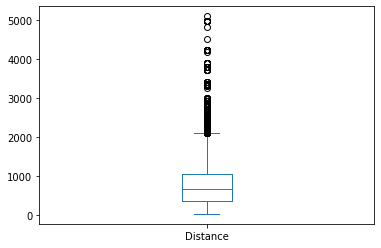

In [17]:
Delay_data.Distance.plot.box()

<AxesSubplot:>

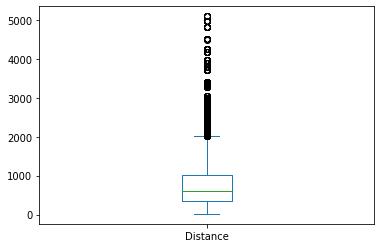

In [18]:
Notdelay_data.Distance.plot.box()

#### airline

In [19]:
Delay_data.Airline.value_counts()

Southwest Airlines Co.                       8682
American Airlines Inc.                       3929
United Air Lines Inc.                        3881
SkyWest Airlines Inc.                        3644
Delta Air Lines Inc.                         3132
JetBlue Airways                              2479
Republic Airlines                            1412
Envoy Air                                    1272
Alaska Airlines Inc.                         1188
Comair Inc.                                  1106
Mesa Airlines Inc.                           1091
Frontier Airlines Inc.                       1083
Spirit Air Lines                             1051
ExpressJet Airlines Inc.                      999
Endeavor Air Inc.                             911
Allegiant Air                                 663
Air Wisconsin Airlines Corp                   550
Trans States Airlines                         509
Horizon Air                                   494
Commutair Aka Champlain Enterprises, Inc.     464


In [20]:
Notdelay_data.Airline.value_counts()

Southwest Airlines Co.                       37462
Delta Air Lines Inc.                         20772
SkyWest Airlines Inc.                        18416
United Air Lines Inc.                        17512
American Airlines Inc.                       16941
JetBlue Airways                               7707
Republic Airlines                             7285
Alaska Airlines Inc.                          6442
Envoy Air                                     5707
Spirit Air Lines                              5386
Comair Inc.                                   5211
Mesa Airlines Inc.                            5188
Endeavor Air Inc.                             5088
ExpressJet Airlines Inc.                      4078
Frontier Airlines Inc.                        3172
Horizon Air                                   2978
Air Wisconsin Airlines Corp                   2919
Allegiant Air                                 2771
Hawaiian Airlines Inc.                        2709
Capital Cargo International    

In [21]:
airline_delaytop = Delay_data.Airline.value_counts()/(Delay_data.Airline.value_counts() + Notdelay_data.Airline.value_counts())
airline_delaytop


Air Wisconsin Airlines Corp                  0.158547
Alaska Airlines Inc.                         0.155701
Allegiant Air                                0.193069
American Airlines Inc.                       0.188261
Cape Air                                     0.107143
Capital Cargo International                  0.160259
Comair Inc.                                  0.175083
Commutair Aka Champlain Enterprises, Inc.    0.284663
Compass Airlines                             0.179654
Delta Air Lines Inc.                         0.131024
Empire Airlines Inc.                         0.126623
Endeavor Air Inc.                            0.151859
Envoy Air                                    0.182261
ExpressJet Airlines Inc.                     0.196770
Frontier Airlines Inc.                       0.254524
GoJet Airlines, LLC d/b/a United Express     0.177959
Hawaiian Airlines Inc.                       0.087572
Horizon Air                                  0.142281
JetBlue Airways             

<AxesSubplot:>

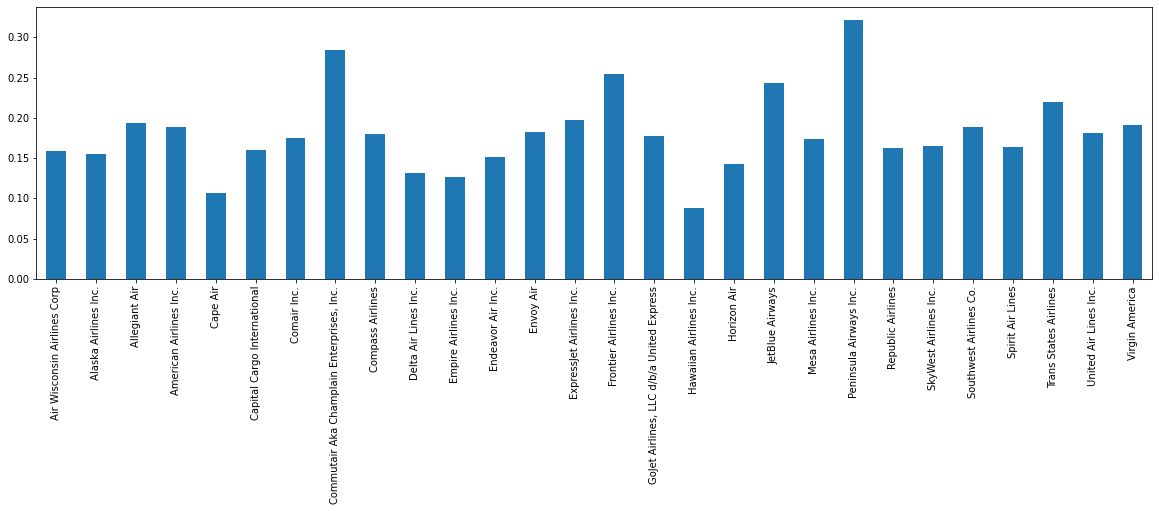

In [22]:
airline_delaytop.plot(kind='bar',figsize=[20,5])

#### date

#### carrier None fill
    IATA와 ID가 동일하면 항공사(airline)를 알 수 있다.
    

##### ID의 null 없애기를 최우선으로
    생각해보니 머신러닝은 문자열을 다시 원-핫이나 레이블 인코딩을 해줘야하니, ID값을 기준으로 모델이 학습하도록 하고 나머지는 컬럼drop하는게 좋지 않을까?

##### 항공사 3columns가 다 없는 경우
    Tail_Number로 fill 가능

In [23]:
for i in Train_data['Carrier_ID(DOT)'].dropna().unique():
    air = Train_data.loc[Train_data['Carrier_ID(DOT)']==i,'Airline'].dropna().unique()
    if len(air) ==1:
        Train_data.loc[Train_data['Carrier_ID(DOT)']==i,'Airline'] = air[0]
        
for i in Train_data['Airline'].dropna().unique():
    air = Train_data.loc[Train_data['Airline']==i,'Carrier_ID(DOT)'].dropna().unique()
    if len(air) ==1:
        Train_data.loc[Train_data['Airline']==i,'Carrier_ID(DOT)'] = air[0]

In [24]:

for i in Train_data.loc[Train_data['Carrier_ID(DOT)'].isnull(),'Tail_Number'].unique():
    air = Train_data.loc[Train_data['Tail_Number']==i,'Carrier_ID(DOT)'].dropna().unique()
    if len(air) == 1:
        Train_data.loc[Train_data['Tail_Number']==i,'Carrier_ID(DOT)'] = air[0]

In [25]:
for i in Train_data.loc[Train_data['Airline'].isnull(),'Tail_Number'].unique():
    air = Train_data.loc[Train_data['Tail_Number']==i,'Airline'].dropna().unique()
    if len(air) == 1:
        Train_data.loc[Train_data['Tail_Number']==i,'Airline'] = air[0]

In [53]:
for i in Train_data.loc[Train_data['Carrier_Code(IATA)'].isnull(),'Tail_Number'].unique():
    air = Train_data.loc[Train_data['Tail_Number']==i,'Carrier_Code(IATA)'].dropna().unique()
    if len(air) == 1:
        Train_data.loc[Train_data['Tail_Number']==i,'Carrier_Code(IATA)'] = air[0]

In [54]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Origin_Airport            1000000 non-null  object 
 6   Origin_Airport_ID         1000000 non-null  int64  
 7   Destination_Airport       1000000 non-null  object 
 8   Destination_Airport_ID    1000000 non-null  int64  
 9   Distance                  1000000 non-null  float64
 10  Airline                   999844 non-null   object 
 11  Carrier_Code(IATA)        997452 non-null   object 
 12  Carrier_ID(DOT)           999844 non-null   float64
 13  Tail_Number               10

In [26]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [27]:
# for문으로 nan 검출하려면 math.isnan()
# for i in Train_data['Carrier_ID(DOT)'].unique():
#     if math.isnan(i) == False: 
#         print(i)

In [28]:
# def standardID_fill(col):
#     if math.isnan(col['Carrier_ID(DOT)']) == False:
#         airline = Train_data[carrierId == col['Carrier_ID(DOT)']].Airline.unique()[0]
#     else:
#         airline = col.Airline
#     return airline

# Train_data['Airline'] = Train_data.apply(standardID_fill,axis=1)

#### 거리가 NaN일 경우
    Date type으로 변환한 후에 !!! (시간 계산이 달라질 수 있음.)
    같은 거리일 경우에도 스케줄 시간(도착시간-출발시간)이 다를 수 있음. 따라서 값이 있는 다른 컬럼들의 평균 값(int변환)에 따라서 값 지정

    -> 다만 시각이 둘 다 없는 경우 어떤형태로 작성할지 고민.


In [29]:
nan_depart = Train_data['Estimated_Departure_Time'].isnull()
nan_arrival = Train_data['Estimated_Arrival_Time'].isnull()

In [30]:
Train_data[nan_depart & nan_arrival]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN
109,TRAIN_000109,3,29,NaN,NaN,0,0,PDX,14057,Oregon,DEN,11292,Colorado,991.0,Southwest Airlines Co.,WN,19393.0,N499WN,NaN
277,TRAIN_000277,8,9,NaN,NaN,0,0,MKE,13342,Wisconsin,IAH,12266,Texas,984.0,Mesa Airlines Inc.,UA,20378.0,N88335,NaN
435,TRAIN_000435,9,12,NaN,NaN,0,0,OAK,13796,California,ORD,13930,Illinois,1836.0,Spirit Air Lines,NK,20416.0,N618NK,NaN
437,TRAIN_000437,7,12,NaN,NaN,0,0,HOU,12191,Texas,MSY,13495,NaN,302.0,Southwest Airlines Co.,WN,19393.0,N265WN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999771,TRAIN_999771,7,10,NaN,NaN,0,0,FLL,11697,Florida,ORD,13930,Illinois,1182.0,JetBlue Airways,B6,20409.0,N529JB,NaN
999777,TRAIN_999777,9,27,NaN,NaN,0,0,STS,15023,California,SEA,14747,Washington,618.0,SkyWest Airlines Inc.,AS,20304.0,N403SY,Delayed
999815,TRAIN_999815,12,1,NaN,NaN,0,0,SEA,14747,Washington,BOI,10713,Idaho,399.0,Horizon Air,AS,19687.0,N401QX,NaN
999911,TRAIN_999911,7,14,NaN,NaN,0,0,HOU,12191,Texas,DEN,11292,Colorado,883.0,Southwest Airlines Co.,WN,19393.0,N935WN,NaN


In [31]:
origin = Train_data['Origin_Airport_ID'] == 13851
destination = Train_data['Destination_Airport_ID'] == 12191

In [32]:
test = Train_data[origin & destination]

In [33]:
test['estimated_mean'] = test['Estimated_Arrival_Time'] - test['Estimated_Departure_Time']

/var/folders/g2/_8d164f53jb5m7yyxjl6mr000000gn/T/ipykernel_76962/4183909609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['estimated_mean'] = test['Estimated_Arrival_Time'] - test['Estimated_Departure_Time']


In [34]:
test.estimated_mean.describe()

count    163.000000
mean     147.576687
std       20.885903
min      115.000000
25%      125.000000
50%      165.000000
75%      165.000000
max      175.000000
Name: estimated_mean, dtype: float64

#### 나머지 결측치 필터링으로 채우기

In [35]:
null_d = Train_data[Train_data['Carrier_ID(DOT)'].isnull()]
null_d

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
4471,TRAIN_004471,12,9,1936.0,2110.0,0,0,MCI,13198,Missouri,ORD,13930,Illinois,403.0,NaN,AA,NaN,N523AE,Not_Delayed
7303,TRAIN_007303,2,28,1100.0,NaN,0,0,SFO,14771,NaN,AUS,10423,Texas,1504.0,NaN,VX,NaN,N637VA,NaN
15218,TRAIN_015218,8,11,2125.0,2227.0,0,0,ORD,13930,Illinois,GRB,11977,Wisconsin,174.0,NaN,UA,NaN,N12163,NaN
15607,TRAIN_015607,4,20,1235.0,1530.0,0,0,ORD,13930,Illinois,RIC,14524,Virginia,642.0,NaN,AA,NaN,N532EA,NaN
17389,TRAIN_017389,7,3,1745.0,2030.0,0,0,SNA,14908,California,SEA,14747,Washington,978.0,NaN,AS,NaN,N621VA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981675,TRAIN_981675,1,27,1035.0,1900.0,0,0,LAX,12892,California,JFK,12478,New York,2475.0,NaN,AS,NaN,N629VA,NaN
982010,TRAIN_982010,12,8,1605.0,1658.0,0,0,LAX,12892,California,SAN,14679,California,109.0,NaN,UA,NaN,N870AS,Not_Delayed
993879,TRAIN_993879,1,3,1420.0,1549.0,0,0,EWR,11618,New Jersey,PIT,14122,Pennsylvania,319.0,NaN,UA,NaN,N16178,NaN
994163,TRAIN_994163,1,15,948.0,1055.0,0,0,ATL,10397,NaN,SGF,14783,Missouri,563.0,NaN,NaN,NaN,N676CA,NaN


In [55]:
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = Train_data.loc[(Train_data['Origin_Airport'] == ori_val[n]) & (Train_data['Destination_Airport'] == dest_val[n]) & (Train_data['Tail_Number'] == tailnum) & (Train_data['Carrier_Code(IATA)'] == iata[n]),'Airline'].dropna().unique()
            print(airline)
            if airline == []:
                continue
            air_id = Train_data.loc[Train_data['Airline'] == airline[0],'Carrier_ID(DOT)'].dropna().unique().astype(int)
            Train_data.loc[idx[n],'Airline'] = airline[0]
            Train_data.loc[idx[n],'Carrier_ID(DOT)'] = air_id
        except:
            pass
        

N12163
[]


/var/folders/g2/_8d164f53jb5m7yyxjl6mr000000gn/T/ipykernel_76962/2052227705.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if airline == []:


[]
[]
N621VA
[]
[]
[]
[]
N750EV
[]
N844VA
[]
N619AE
[]
[]
[]
[]
[]
N923VA
[]
[]
N523AE
[]
N841VA
[]
[]
N526VA
[]
N856AS
[]
N637VA
[]
[]
N641VA
[]
[]
N607AE
[]
N525VA
[]
N527VA
[]
N285VA
[]
[]
[]
N655AE
[]
N753EV
[]
N628VA
[]
[]
N676CA
[]
[]
[]
N846VA
[]
[]
N610AE
[]
N847VA
[]
N529VA
[]
N909EV
[]
N626VA
[]
N606AE
[]
N854AS
[]
[]
N317CA
[]
N639VA
[]
[]
N740EV
[]
[]
N921VA
[]
[]
[]
N195PQ
[]
[]
['Endeavor Air Inc.']
N862AS
[]
[]
N361VA
[]
N371CA
['Endeavor Air Inc.']
[]
N836VA
[]
N652RS
[]
N678CA
[]
[]
N623AE
[]
N284VA
[]
N840VA
[]
N860AS
[]
N524AE
[]
N14168
[]
[]
N871AS
[]
N851VA
[]
N147PQ
[]
[]
[]
N530VA
[]
[]
[]
N12172
[]
[]
['Commutair Aka Champlain Enterprises, Inc.']
N650AE
[]
[]
N867DA
[]
N754EV
[]
N922VA
[]
N538CA
[]
[]
N758EV
[]
N658AE
['Capital Cargo International']
[]
[]
[]
N903EV
[]
[]
[]
[]
N722EV
[]
N624VA
[]
N146PQ
[]
N533AE
[]
[]
N645AE
[]
N853VA
[]
N23139
[]
N17169
[]
N644AE
[]
N605KS
[]
N842VA
[]
[]
[]
N691CA
[]
[]
N506AE
[]
N657AE
[]
[]
N522VA
[]
[]
N855VA
[]
N615AE
[]


In [56]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Origin_Airport            1000000 non-null  object 
 6   Origin_Airport_ID         1000000 non-null  int64  
 7   Destination_Airport       1000000 non-null  object 
 8   Destination_Airport_ID    1000000 non-null  int64  
 9   Distance                  1000000 non-null  float64
 10  Airline                   999849 non-null   object 
 11  Carrier_Code(IATA)        997452 non-null   object 
 12  Carrier_ID(DOT)           999849 non-null   float64
 13  Tail_Number               10

In [112]:
null_d = Train_data[Train_data['Carrier_ID(DOT)'].isnull()]
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = Train_data.loc[(Train_data['Origin_Airport'] == ori_val[n]) & (Train_data['Tail_Number'] == tailnum),'Airline'].dropna().unique()
            print(idx[n],airline[0])
            if len(airline) == 1 :
                air_id = Train_data.loc[Train_data['Airline'] == airline[0],'Carrier_ID(DOT)'].dropna().unique().astype(int)
                uniq_iata = Train_data.loc[Train_data['Airline'] == airline[0],'Carrier_Code(IATA)'].dropna().unique()
                Train_data.loc[idx[n],'Airline'] = airline[0]
                Train_data.loc[idx[n],'Carrier_ID(DOT)'] = air_id
            if len(uniq_iata) == 1:
                Train_data.loc[idx[n],'Carrier_Code(IATA)'] = uniq_iata[0]
        except:
            pass
        

N750EV
N923VA
46931 Alaska Airlines Inc.
N841VA
51919 Alaska Airlines Inc.
762926 Alaska Airlines Inc.
N526VA
53152 Alaska Airlines Inc.
N527VA
N610AE
N909EV
N285VA
171762 Alaska Airlines Inc.
N606AE
N854AS
190607 ExpressJet Airlines Inc.
N921VA
217252 Virgin America
N195PQ
235759 Endeavor Air Inc.
N862AS
N361VA
261008 Alaska Airlines Inc.
N836VA
286721 Alaska Airlines Inc.
N652RS
N678CA
N840VA
332502 Alaska Airlines Inc.
N860AS
N524AE
N14168
356692 Commutair Aka Champlain Enterprises, Inc.
N871AS
N851VA
359567 Alaska Airlines Inc.
N530VA
375551 Alaska Airlines Inc.
422778 Alaska Airlines Inc.
481714 Virgin America
N867DA
N922VA
386741 Alaska Airlines Inc.
N538CA
386969 Endeavor Air Inc.
887147 Endeavor Air Inc.
N758EV
389971 SkyWest Airlines Inc.
N903EV
557580 ExpressJet Airlines Inc.
619215 ExpressJet Airlines Inc.
N624VA
492503 Alaska Airlines Inc.
N533AE
N846VA
537323 Alaska Airlines Inc.
N23139
N619AE
N17169
568284 Commutair Aka Champlain Enterprises, Inc.
N605KS
N842VA
594470 Ala

In [113]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Origin_Airport            1000000 non-null  object 
 6   Origin_Airport_ID         1000000 non-null  int64  
 7   Destination_Airport       1000000 non-null  object 
 8   Destination_Airport_ID    1000000 non-null  int64  
 9   Distance                  1000000 non-null  float64
 10  Airline                   999937 non-null   object 
 11  Carrier_Code(IATA)        997470 non-null   object 
 12  Carrier_ID(DOT)           999937 non-null   float64
 13  Tail_Number               10

In [129]:
tailnum = 'N923VA'
idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
n = 0
# Train_data.loc[(Train_data['Origin_Airport'] == val[n])& (Train_data['Destination_Airport'] == dest_val[n]) & (Train_data['Tail_Number'] == tailnum) & (Train_data['Carrier_Code(IATA)'] == iata[n])]
ex = Train_data.loc[(Train_data['Tail_Number'] == tailnum)]
ex
# idx,val,iata

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Destination_Airport,Destination_Airport_ID,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
26789,TRAIN_026789,3,17,1410.0,2240.0,LAX,12892,JFK,12478,2475.0,Alaska Airlines Inc.,AS,19930.0,N923VA,NaN
46931,TRAIN_046931,8,15,1030.0,1850.0,LAX,12892,PHL,14100,2402.0,NaN,NaN,NaN,N923VA,NaN
57347,TRAIN_057347,5,15,930.0,1245.0,JFK,12478,LAX,12892,2475.0,Alaska Airlines Inc.,AS,19930.0,N923VA,Delayed
63942,TRAIN_063942,12,10,930.0,1808.0,SFO,14771,BOS,10721,2704.0,Alaska Airlines Inc.,AS,19930.0,N923VA,NaN
71024,TRAIN_071024,5,19,1310.0,2200.0,SFO,14771,JFK,12478,2586.0,Alaska Airlines Inc.,AS,19930.0,N923VA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969394,TRAIN_969394,7,29,2125.0,NaN,LAX,12892,PDX,14057,834.0,Alaska Airlines Inc.,AS,19930.0,N923VA,NaN
972989,TRAIN_972989,10,5,930.0,1250.0,JFK,12478,SEA,14747,2422.0,Alaska Airlines Inc.,AS,19930.0,N923VA,NaN
983467,TRAIN_983467,4,17,1855.0,2229.0,JFK,12478,SFO,14771,2586.0,Alaska Airlines Inc.,AS,19930.0,N923VA,Not_Delayed
987455,TRAIN_987455,4,11,NaN,2229.0,JFK,12478,SFO,14771,2586.0,Alaska Airlines Inc.,AS,19930.0,N923VA,NaN


In [50]:
Train_data.drop(columns=['Cancelled','Diverted','Origin_State','Destination_State'],inplace=True)

In [52]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 15 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Origin_Airport            1000000 non-null  object 
 6   Origin_Airport_ID         1000000 non-null  int64  
 7   Destination_Airport       1000000 non-null  object 
 8   Destination_Airport_ID    1000000 non-null  int64  
 9   Distance                  1000000 non-null  float64
 10  Airline                   999844 non-null   object 
 11  Carrier_Code(IATA)        891010 non-null   object 
 12  Carrier_ID(DOT)           999844 non-null   float64
 13  Tail_Number               10

In [114]:
Train_data[Train_data['Carrier_ID(DOT)'].isnull()]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Destination_Airport,Destination_Airport_ID,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
41358,TRAIN_041358,4,10,1459.0,1623.0,ROC,14576,LGA,12953,254.0,NaN,DL,NaN,N750EV,NaN
46931,TRAIN_046931,8,15,1030.0,1850.0,LAX,12892,PHL,14100,2402.0,NaN,NaN,NaN,N923VA,NaN
51919,TRAIN_051919,12,16,1225.0,1838.0,SFO,14771,MSY,13495,1911.0,NaN,NaN,NaN,N841VA,Delayed
53152,TRAIN_053152,9,17,610.0,835.0,SFO,14771,SEA,14747,679.0,NaN,AS,NaN,N526VA,Not_Delayed
113700,TRAIN_113700,4,24,1755.0,2107.0,MSY,13495,SFO,14771,1911.0,NaN,AS,NaN,N527VA,Not_Delayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948716,TRAIN_948716,5,8,735.0,908.0,DAL,11259,LAX,12892,1246.0,NaN,NaN,NaN,N621VA,NaN
965234,TRAIN_965234,2,10,1220.0,1450.0,DFW,11298,MSP,13487,852.0,NaN,DL,NaN,N131EV,Delayed
972437,TRAIN_972437,10,1,1916.0,1938.0,DAY,11267,ORD,13930,240.0,NaN,AA,NaN,N658AE,NaN
993879,TRAIN_993879,1,3,1420.0,1549.0,EWR,11618,PIT,14122,319.0,NaN,UA,NaN,N16178,NaN
